In [139]:
from py2neo import Graph, Node, Relationship
from neo4j import GraphDatabase
import networkx as nx
import pandas as pd
import json
import matplotlib.pyplot as plt
import heapq
import osmnx as ox


In [16]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "password"))

In [174]:
# Map bounds algorithm
# Helper function to generate a subgraph from the UI bounds
# Input: 2 coordinates representing the box of the UI map
# Output: NetworkX graph

c1 = (46.73452, -117.1886249)
c2 = (46.7346887, -117.1886485)


def createGraph(coord1, coord2):
  lats = (coord1[0], coord2[0])
  lons = (coord1[1], coord2[1])


  # Example values for testing
  max_lat = max(lats)
  min_lat = min(lats)
  max_lon = max(lons)
  min_lon = min(lons)

  # Calculate the distance
  query = f"""
  WITH
    point({{longitude: {min_lon}, latitude: {min_lat}}}) AS low,
    point({{longitude: {max_lon}, latitude: {max_lat}}}) AS high
  RETURN point.distance(low, high) AS Distance, low, high
  """

  with driver.session(database='neo4j') as session:
      result = session.run(query) # All edges in bounding box   
      data = result.data()
      margin = data[0]['Distance'] / (111045 * 2) #Distance in terms of lat/lon degrees * 2. Box is expanded by 50%
      x = data[0]['low']
      y = data[0]['high']
      lons = [x.x, y.x]
      lats = [x.y, y.y]
      max_lat = max(lats) + margin # Increase the box size in relation to the distance between the two nodes
      min_lat = min(lats) - margin
      max_lon = max(lons) + margin
      min_lon = min(lons) - margin

  # Get nodes and edges in bounding box
  query_one = """
  WITH
    point({{longitude: {max_lon}, latitude: {min_lat}}}) AS lowerLeft,
    point({{longitude: {min_lon}, latitude: {max_lat}}}) AS upperRight
  MATCH (n:Node)-[r:Road]->(m:Node)
  WHERE point.withinBBox(point({{longitude: n.lon, latitude: n.lat}}), lowerLeft, upperRight)
  AND point.withinBBox(point({{longitude: m.lon, latitude: m.lat}}), lowerLeft, upperRight)
  RETURN n, r.distance, r.id, r.centrality, m
  """.format(min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat)


  G = nx.Graph()
  with driver.session(database='neo4j') as session:
      result = session.run(query_one) 
      data = result.data()

  for i in data:
    id1 = i['n']['id']
    id2 = i['m']['id']
    distance = i['r.distance']
    id0 = i['r.id']
    G.add_edge(id1, id2, weight=distance, id=id0)

  return G

G = createGraph(c1, c2)
print(len(G.nodes))

105


In [175]:

paths = {}
# Store all the shortest path calculations. This has the possibility to increase performance and make use of pre-calcuations
def cacheShortestPath(A, B, path):
    paths[(A,B)] = path

# Find the shortest path between two nodes
def dijkstra(graph, source, target = None):
    distance = {node: float('inf') for node in graph.nodes()}
    distance[source] = 0
    path = [target]
    target_node = target
    prev = {}
    total_distance = 0

    pq = [(0, source)]

    while pq:

        # This algorithm uses a priortity queue to find the nodes with the smallest distance
        # In this case, we don't have to loop over visited nodes to find the minimum distance (O(log N) vs O(N))
        dist, node = heapq.heappop(pq) 

        if node == target and target != None: #If target is None, the algorithm will find distances to all nodes. Needed for centrality algorithm
            break

        # # Skip the node if we have already processed it
        # if dist > distance[node]:
        #     continue
        
        for neighbor in graph.neighbors(node): #Get all neighbor nodes
            edge_weight = graph[node][neighbor].get('weight', 1) #Get the weighted distance between the nodes and neighbor, defaults to 1
            temp_distance = distance[node] + edge_weight
            if temp_distance < distance[neighbor]: #Updates the temporary total distance
                distance[neighbor] = temp_distance
                total_distance = temp_distance
                prev[neighbor] = node #Used to trace the path
                # Add the neighbor to the priority queue with its updated distance
                heapq.heappush(pq, (temp_distance, neighbor))

    # Building shortest the path
    # prev = {'B': 'A', 'C': 'A', 'D': 'B'} = A -> B, B -> D; A -> C
    # Works backwards from target to the source node
    if target is not None:
        try:
            while target != source:
                target = prev[target]
                path.append(target)
            path.reverse()
            cacheShortestPath(source, target_node, path)
        except:
            pass

    distance = {key: value for key, value in sorted(distance.items(), key=lambda item: item[0]) if not value == float('inf')}
    return path, distance



In [166]:
#Upload centraility measures to Neo4j
def updateNeo4j(centrality):
    for edge, centrality in centrality.items():
        data = G.get_edge_data(edge[0], edge[1])
        id = data['id']

        query = """
        MATCH (a:Node)-[r:Road]->(b:Node) 
        WHERE r.id = {id} 
        SET r.centrality = {centrality}
        """.format(id=id, centrality=centrality)

        with driver.session(database='neo4j') as session:
            result = session.run(query)    
            data = result.data()

In [167]:
# Calculate the betweenness centraility for the subgraph
# This function identifies all possible shortest paths and provides a measure of importance for every edge
# An edge will have a higher importance if its part of more paths
def betweenness_centrality(graph):
    edge_centrality = {}
    
    # Initialize the centrality for all edges
    for edge in graph.edges():
        edge_centrality[edge] = 0.0
    
    for node in graph: #Loop through all combination of nodes
        for source in graph:
            if source == node:
                continue

            # Get all connected paths from the source node and return the distance
            xyz, shortest_paths = dijkstra(G, source)
            num_shortest_paths = {}

            # For each combination, get the edges part of the shortest path
            for target_node, length in shortest_paths.items():
                if target_node != source and target_node != node:
                    path, xyz = dijkstra(graph, source, target_node) #Get the shortest path
                    for i in range(len(path) - 1):
                        edge = (path[i], path[i + 1]) #Get the edges from the shortest path
                        if edge not in num_shortest_paths: #Update edge counts
                            num_shortest_paths[edge] = 1
                        else:
                            num_shortest_paths[edge] += 1

            # Accumulate edge betweenness centrality
            for edge in num_shortest_paths:
                try:
                    edge_centrality[edge] += (num_shortest_paths[edge] / shortest_paths[target_node]) #Ratio of shortest paths passing through the edge and all possible shortest paths in the graph
                except:
                    pass

    return edge_centrality

# Calculate edge betweenness centrality for the weighted graph
centrality = betweenness_centrality(G)
updateNeo4j(centrality)


In [168]:
################## Validation ##################

# Testing data
G = nx.Graph()
G.add_edge('A', 'B', weight=5, id=123)
G.add_edge('A', 'C', weight=1, id=1345)
G.add_edge('B', 'C', weight=2, id=6193835)
G.add_edge('B', 'D', weight=5, id=6193835)
G.add_edge('C', 'D', weight=4, id=6193835)
G.add_edge('D', 'E', weight=3, id=6193835)

source_node = 'A'
target_node = 'D'

shortest_path, d = dijkstra(G, source_node, target_node)

print(shortest_path)

# Validate output with the built-in function
path = nx.shortest_path(G, source_node, target_node, weight='weight')
print(path)

# Get the distances from the source_node to All nodes
x, y = dijkstra(G, source_node)
print({key: value for key, value in sorted(y.items(), key=lambda item: item[0])}) #Sort dictionary

# Validate with built-in NetworkX function
shortest_paths = nx.single_source_dijkstra_path_length(G, source_node, weight='weight')
print({key: value for key, value in sorted(shortest_paths.items(), key=lambda item: item[0])})

betweenness_centrality = betweenness_centrality(G)

for edge, centrality in betweenness_centrality.items():
    print(f'Edge: {edge}, Betweenness Centrality: {centrality:.2f}')

['A', 'C', 'D']
['A', 'C', 'D']
{'A': 0, 'B': 3, 'C': 1, 'D': 5, 'E': 8}
{'A': 0, 'B': 3, 'C': 1, 'D': 5, 'E': 8}
Edge: ('A', 'B'), Betweenness Centrality: 0.00
Edge: ('A', 'C'), Betweenness Centrality: 1.50
Edge: ('B', 'C'), Betweenness Centrality: 0.75
Edge: ('B', 'D'), Betweenness Centrality: 0.75
Edge: ('C', 'D'), Betweenness Centrality: 1.61
Edge: ('D', 'E'), Betweenness Centrality: 2.18


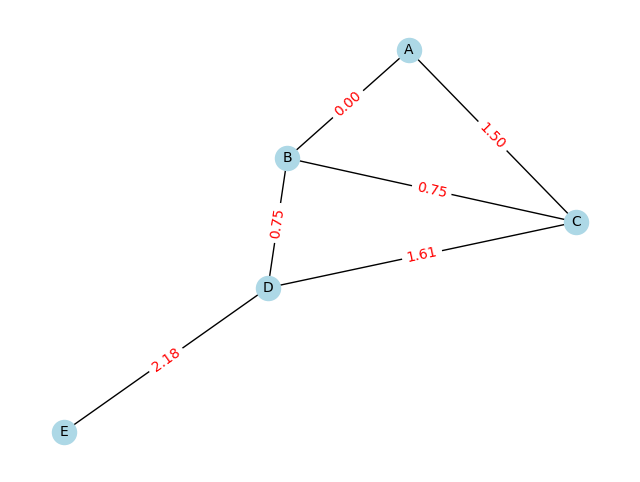

In [169]:

#################### Visualizations #################################

# Plot the centraility values
def plot_betweenness_centraility(G, centrality):
    edges = [(edge[0], edge[1]) for edge in G.edges()]
    edge_centrality_values = [centrality[edge] for edge in G.edges()]
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Draw the graph
    pos = nx.spring_layout(G)  # You can choose different layout algorithms
    nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightblue', font_size=10, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={edge: f"{betweenness_centrality[edge]:.2f}" for edge in G.edges()}, font_color='red')
    plt.show()

x = plot_betweenness_centraility(G, betweenness_centrality)

# Centraility with the osm package
def osmCentrality(G):
    edges_centrality = nx.edge_betweenness_centrality(G, weight='length')
    nodes_centrality = nx.betweenness_centrality(G, weight='length')
    for (u, v, i), centrality in edges_centrality.items():
        G[u][v][i]['centrality'] = centrality
    for node, centrality in nodes_centrality.items():
        G.nodes[node]['centrality'] = centrality
    ox.plot_graph(G, node_color=ox.plot.get_node_colors_by_attr(G, attr='centrality'), edge_color=ox.plot.get_edge_colors_by_attr(G, attr='centrality'))


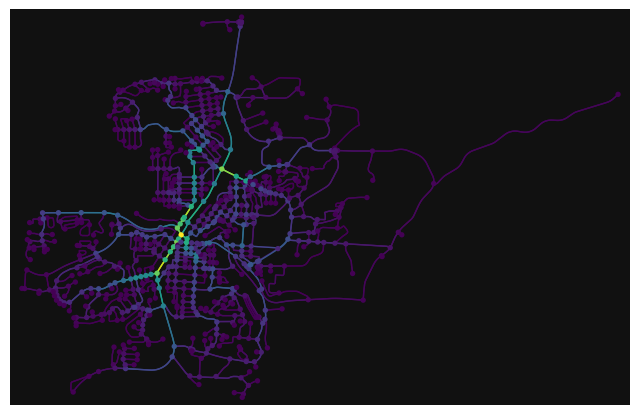

In [170]:
# Provides an idea of what will be shown in the UI 
G = ox.graph_from_place("Pullman, WA", network_type="drive")
osmCentrality(G)